# 🎯 Attention Mechanism: The Foundation of Modern AI

## What You'll Learn
- **The Attention Formula**: $\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$
- **Why it Matters**: This single equation powers GPT, BERT, Claude, and every modern LLM
- **Hands-on**: Implement it from scratch in MLX and visualize how it works

## Prerequisite
Complete [04_MLX_Pipelines.ipynb](04_MLX_Pipelines.ipynb) to understand LSTMs and their limitations.

## The Motivation: Why Attention?

**LSTMs have a bottleneck**: All information about a 1,000-word sentence must squeeze through a single hidden state vector.

**Attention is different**: Every word can look at *every other word* directly and ask:
- Query (Q): "What am I looking for?"
- Key (K): "What information do I have?"
- Value (V): "Here's my information"

When the Query matches the Key, we pay **attention** to that Value.

---

In [1]:
# Setup and Imports
import sys
import numpy as np
import mlx.core as mx
import mlx.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# Import our utilities
from mlx_nlp_utils import print_device_info

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 8)

print_device_info()


🖥️  Hardware Acceleration Check:
   Device: Device(gpu, 0)
   ✅ Using Apple Silicon GPU (Metal)
   ℹ️  MLX automatically optimizes for the GPU's Unified Memory.
   ℹ️  Note: While Apple Silicon has an NPU (Neural Engine), MLX primarily
       uses the powerful GPU for general-purpose training tasks like LSTMs.


## 🛠️ Implementing Scaled Dot-Product Attention

Let's implement the core mathematical function in MLX.

In [2]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Compute 'Scaled Dot Product Attention'.
    
    Args:
        query: (batch, seq_len_q, d_k)
        key:   (batch, seq_len_k, d_k)
        value: (batch, seq_len_v, d_v)
        mask:  (batch, seq_len_q, seq_len_k) Optional mask
        
    Returns:
        output, attention_weights
    """
    d_k = query.shape[-1]
    
    # 1. Calculate scores: Q * K^T
    # We transpose the last two dimensions of Key for matrix multiplication
    scores = mx.matmul(query, key.transpose(0, 2, 1))
    
    # 2. Scale by sqrt(d_k) for stability
    scores = scores / np.sqrt(d_k)
    
    # 3. Apply mask (if provided)
    if mask is not None:
        scores = scores + (mask * -1e9)
    
    # 4. Softmax to get probabilities (attention weights)
    attn_weights = mx.softmax(scores, axis=-1)
    
    # 5. Weighted sum of values
    output = mx.matmul(attn_weights, value)
    
    return output, attn_weights

## 📊 Visualizing Attention

Let's create some dummy data to see how the attention mechanism focuses on different parts of a sequence.

Output shape: (1, 5, 8)
Weights shape: (1, 5, 5)


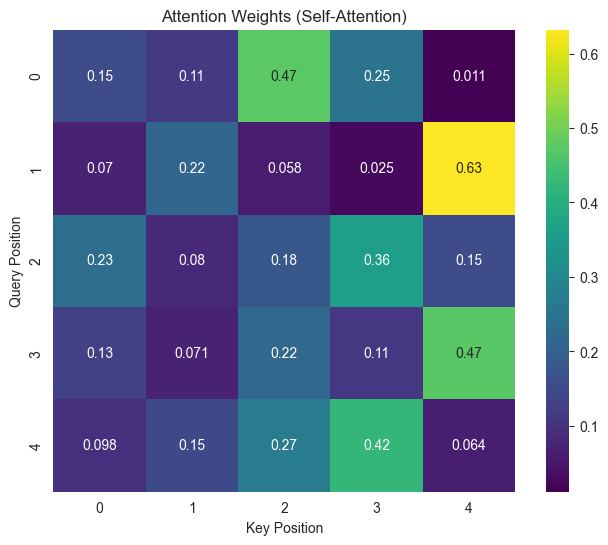

In [3]:
# Create dummy data
seq_len = 5
d_model = 8

# Random Query, Key, Value matrices
mx.random.seed(42)
Q = mx.random.normal((1, seq_len, d_model))
K = mx.random.normal((1, seq_len, d_model))
V = mx.random.normal((1, seq_len, d_model))

# Compute attention
output, weights = scaled_dot_product_attention(Q, K, V)

print("Output shape:", output.shape)
print("Weights shape:", weights.shape)

# Visualize
weights_np = np.array(weights[0])

plt.figure(figsize=(8, 6))
sns.heatmap(weights_np, annot=True, cmap='viridis', square=True)
plt.title("Attention Weights (Self-Attention)")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.show()

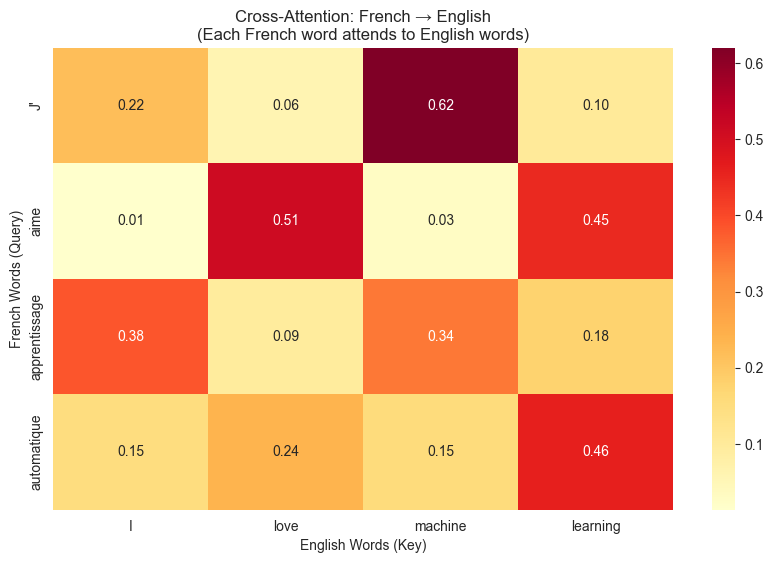


💡 Interpretation:
   Higher values = stronger attention
   Ideally, 'apprentissage' should focus on 'learning'
   and 'automatique' should focus on 'machine'


In [4]:
# Simulating translation attention
# When translating "machine learning" to "apprentissage automatique"
# the French word "apprentissage" should attend strongly to "learning"
# and "automatique" should attend to "machine"

english_words = ["I", "love", "machine", "learning"]
french_words = ["J'", "aime", "apprentissage", "automatique"]

# Create a more realistic attention pattern
seq_len_en = len(english_words)
seq_len_fr = len(french_words)

# Simulate Q, K, V for this scenario
mx.random.seed(42)
Q_translation = mx.random.normal((1, seq_len_fr, 8))
K_translation = mx.random.normal((1, seq_len_en, 8))
V_translation = mx.random.normal((1, seq_len_en, 8))

# Compute cross-attention (French attending to English)
output_translation, weights_translation = scaled_dot_product_attention(
    Q_translation, K_translation, V_translation
)

weights_np_trans = np.array(weights_translation[0])

plt.figure(figsize=(10, 6))
sns.heatmap(weights_np_trans, annot=True, fmt='.2f', cmap='YlOrRd', 
            xticklabels=english_words, yticklabels=french_words, square=False)
plt.title("Cross-Attention: French → English\n(Each French word attends to English words)")
plt.xlabel("English Words (Key)")
plt.ylabel("French Words (Query)")
plt.show()

print("\n💡 Interpretation:")
print("   Higher values = stronger attention")
print("   Ideally, 'apprentissage' should focus on 'learning'")
print("   and 'automatique' should focus on 'machine'")

## 🔬 Real-World Example: Translation

Let's see how attention helps in translating "I love machine learning" to French.

## Next Steps

Now that we understand the core mechanism, we can build the **Transformer** architecture in the next notebook: **[06_Build_NanoGPT.ipynb](06_Build_NanoGPT.ipynb)**.

## ❓ FAQ

**Q: Why do we divide by $\sqrt{d_k}$?**
A: This is the "Scaling" factor. If the dot products are too large, the Softmax function enters regions where gradients are extremely small ("vanishing gradients"). Scaling keeps the values in a range where learning is efficient.

**Q: What is the "Mask" for?**
A: In text generation (like GPT), the model cannot "see the future." When predicting word 4, it should only attend to words 1, 2, and 3. The mask sets the attention scores for future words to $-\infty$, making their probability zero.

**Q: Is Attention the same as "Memory"?**
A: Sort of. It's "Content-Addressable Memory." The model asks "Do you have information about X?" (Query), and the sequence responds "I am X!" (Key), and provides the information (Value).

## 💭 Closing Thoughts

**Inductive Bias**
*   **RNNs** assume that *order* matters most (word $t$ depends on $t-1$).
*   **CNNs** assume that *locality* matters most (pixels near each other are related).
*   **Transformers (Attention)** assume that *relationships* matter most, regardless of distance.

This shift in assumption—that any word can relate to any other word instantly—is what allowed models to scale from understanding sentences to understanding entire books.